**I can confirm that this is my own work, except where clearly indicated**

### Contents

**1) Introduction- Framing the Problem**

**2) Import and Tidy the Data**

**3) Exploratory Data Analysis**

**4) Preparing the Data for Machine Learning Algorithms**

**5) The ROC Curve and AUC Score as a Measure of Performance**

**6) Fitting and Training Machine Learning Models**

    a) Logistic Regression

    b) Random Forest Regressor

    c) Neural Network
    
**7) Fine-Tune Models**    

    a) Number of Hidden Layers
    
    b) Number of Neurons per Hidden Layer
    
    c) Learning Rate

**8) Assess Model Performance**

**9) Conclusions**

**References**

## 1) Introduction- Framing the Problem

The objective of this assignment is to build a model that predicts the probability that individual motorists will initiate an auto insurance claim within the next year. The problem itself is one of classification, however the predicted probabilities of making a claim are of more interest, as often they are far below 0.5, suggesting that none of the models would classify any individuals as making a claim. This was due to only 3.64% of individuals in the training data making a claim and caused also by a lack of correlation between the target variable and most of the features, suggesting that the features lacked enough information to fully explain differences in the claims rate between individuals. The classification problem can be expressed as follows:

$$y_i = f(X_i, \theta)$$

In this case, the response, $y_i$, is the probability that individual i makes a claim within the next year. It could also be converted into a prediction ('claim' or 'no claim') by assigning a threshold; if the probability of claiming is greater than this threshold, the individual is predicted to make a claim, otherwise they are not predicted to make a claim. The goal of machine learning is to find and estimate a model, $f(X_i, \theta)$, that takes as its arguments the data for the ith instance ($X_i$) and the estimated parameter values ($\theta$), and provides the most accurate predictions on unseen data.

In general, one aims to find the model that makes these best predictions, either by classifying the individuals into 'claim' or 'no claim' as accurately as possible, or providing probabilities that each individual will claim that are as close as possible to the true, underlying probabilites (which may be unknown). However, in this situation, it may also be prudent to consider measures of performance that take into account the economic implications of incorrectly predicting an individual won't claim when in fact they do. Equivalently, it may be more economical to overpredict the probabilities that certain individuals will claim, rather that underpredict these. Later, we use the ROC curve and the Area Under Curve (AUC) to compare the performance of models that takes these ideas into account by implicitly considering false negatives when comparing model performance.

We implement a Logistic Regression, Random Forest classification and Neural Network and the justification for these models is presented in Section 6. The performance of all models is assessed by 3-fold cross-validation, using the AUC score as a measure of model performance.

## 2) Import and Tidy the Data

The first step is to import the data, assess its structure and perform any preliminary steps to tidy the data.

In [1]:
#import relevant libraries
#Numpy for scientific computation
import numpy as np
#Pandas for data manipulation
import pandas as pd
#Matplotlib plotting library
%matplotlib inline
import matplotlib.pyplot as plt
#Seaborn for statistical data visualization
import seaborn as sns

In [2]:
#import test and training data
training_data = pd.read_csv("C:/Users/User/Documents/St Andrews/Datamining/Project 2/train.csv")
test_data = pd.read_csv("C:/Users/User/Documents/St Andrews/Datamining/Project 2/test.csv")

In [3]:
#Assess the structure of the data
training_data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


The data contains 57 features, which are a range of categorical, binomial and continuous variables, the column of target values and an id indicating a unique identity for each individual. The training data constitutes instances for 595212 individuals.

In [4]:
print("Number of instances in the training set:", len(training_data))

Number of instances in the training set: 595212


In [5]:
#summary of the training data
training_data.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From the above, some of the continuous features have right-skew in their distributions, such as 'ps_ind_01', with a mean value of 1.9 that is much lower than its maximum value and upper quartile. Later some of these continuous variables will be scaled to improve the performance of the models that are fitted to the data.

In [6]:
#The test data contains no target variable
test_data.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


In [7]:
print("Number of instances in the test data:", len(test_data))

Number of instances in the test data: 892816


In [8]:
test_data.describe()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,8.928160e+05,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,...,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,7.441535e+05,1.902371,1.358613,4.413734,0.417361,0.408132,0.393246,0.257191,0.163659,0.185905,...,5.438478,1.440265,2.875013,7.540367,0.123720,0.627756,0.554660,0.287796,0.349344,0.152428
std,4.296830e+05,1.986503,0.663002,2.700149,0.493453,1.355068,0.488471,0.437086,0.369966,0.389030,...,2.330081,1.200620,1.694072,2.745882,0.329262,0.483403,0.497004,0.452736,0.476763,0.359435
min,0.000000e+00,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.720218e+05,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.443070e+05,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.116308e+06,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488026e+06,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,20.000000,11.000000,15.000000,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


A simple visual comparison of the mean of each feature for the test data suggests it is very similar to that of the training data.

## 3) Exploratory Data Analysis

### Summary of the Features

In order to understand the relationships between the different features and the binary response, and to assess the structure of each of the variables, the following information was gathered to provide a brief summary of the groups of features:

- Target: Binary response variable indicating a claim (1) or no claim (0)
- IND: these 18 variables refer to characeristics of each individual driver
- REG: 3 variables that refer to the region of the claim
- CAR: 16 variables related to the particular car of each individual on which the claim was made
- CALL: 10 variables, which are feature engineered variables relating to the theory behind pricing of autoinsurance quotations


Missing values for the binary variables are indicated by a -1, whilst the postfix 'bin' indicates binary features and 'cat' indicates categorical features. Features without a postfix are numerical. The exact meaning of each individual feature is not available (Porto Seguro's Safe Driver Prediction- Welcome, 2017).

Histograms show the distribution of each feature. We separate the plotting of histograms of the features by the four feature types as discussed above, which makes it easier to visualise the distributions of features within groups. These histograms also include missing values (-1 in value) for each of the features, which enables us to assess which features contain the majority of missing values and also understand how each feature should be prepared for machine learning algorithms.

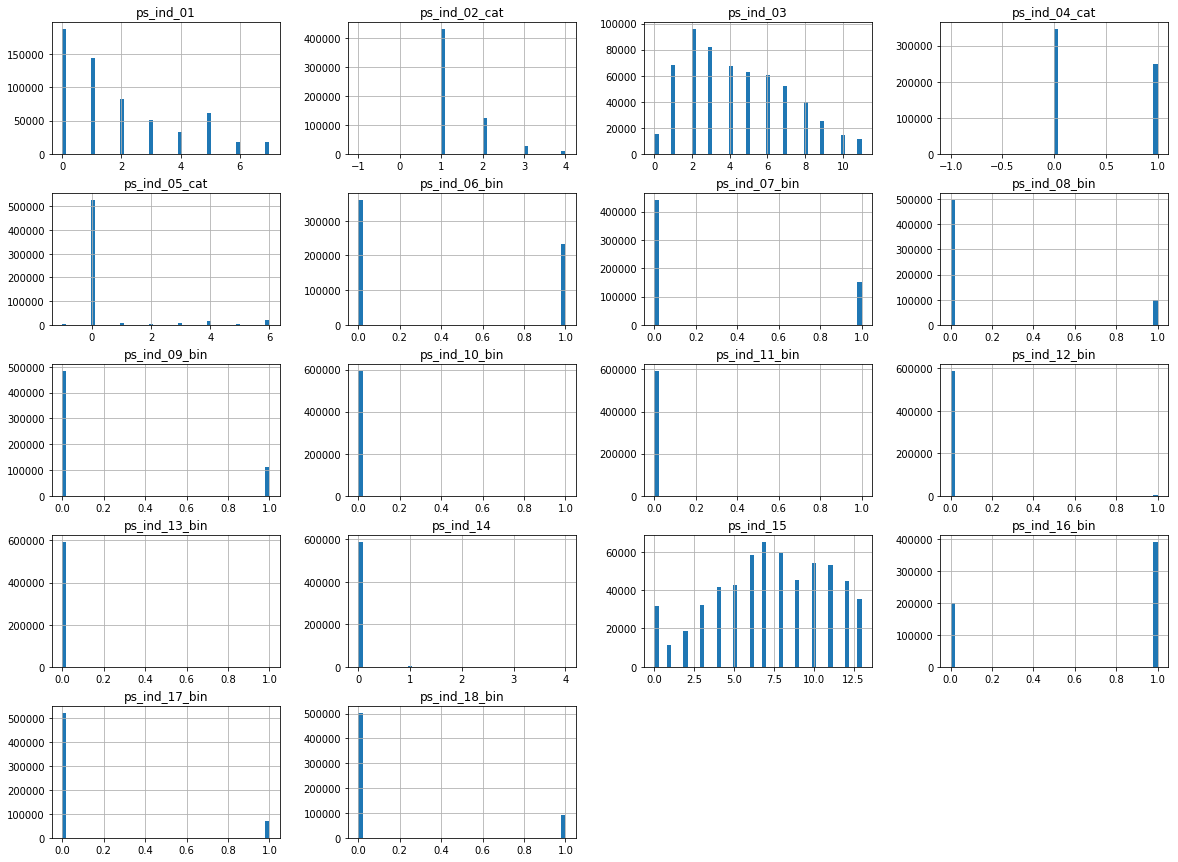

In [9]:
#histogram for each 'individual-related' feature in the dataset
training_data.iloc[:, 2: 20].hist(bins = 50, figsize = (20, 15))
plt.show()

The attributes that relate to individual characteristics are mainly binary and contain few missing values. 

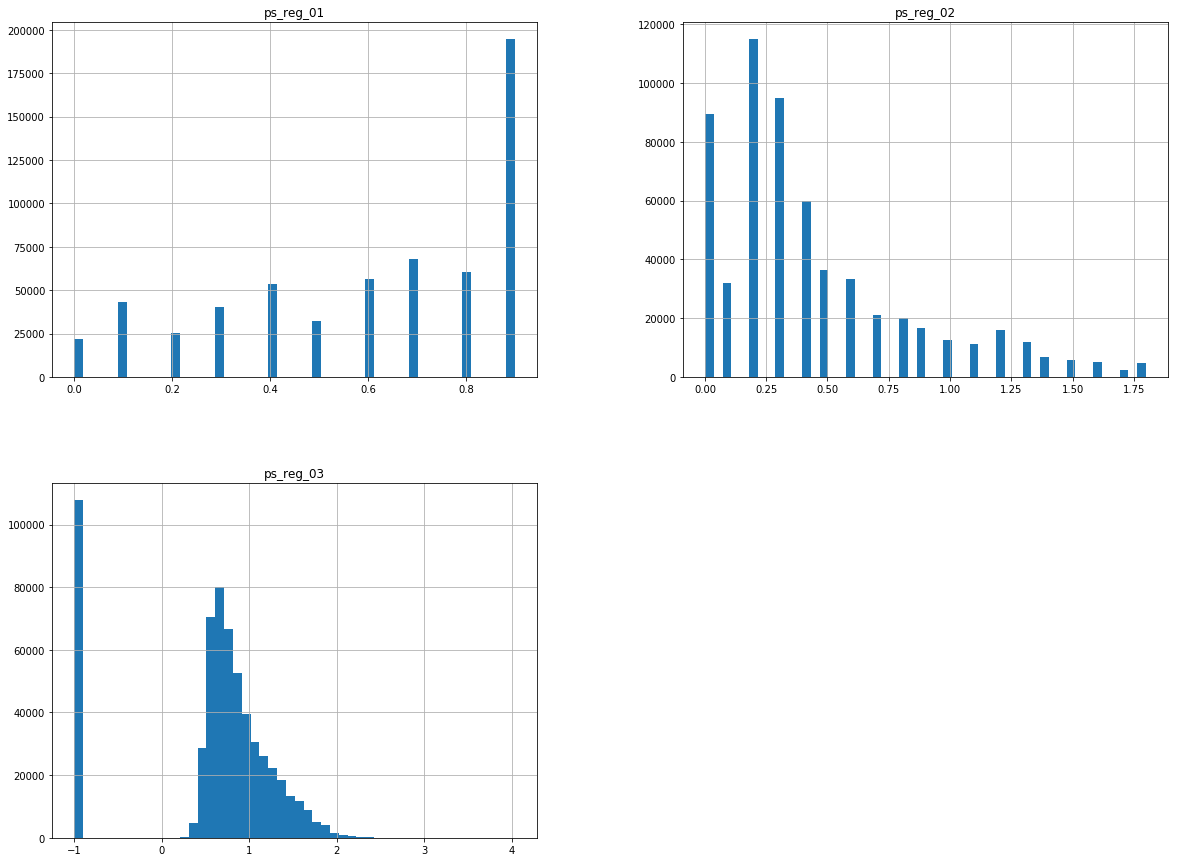

In [10]:
#histogram for each 'Regional-based' feature in the dataset
training_data.iloc[:, 20: 23].hist(bins = 50, figsize = (20, 15))
plt.show()

The attribute 'ps_reg_03' contains a large number of missing values and this is something we may need to take into consideration. All three attributes of the 'region-based' features are either left or right skewed, so will be normalized to lie in the interval (0,1), after removing missing values. They also contain no clear outliers, so scaling in this way will not be adversely affected by outlying observations.

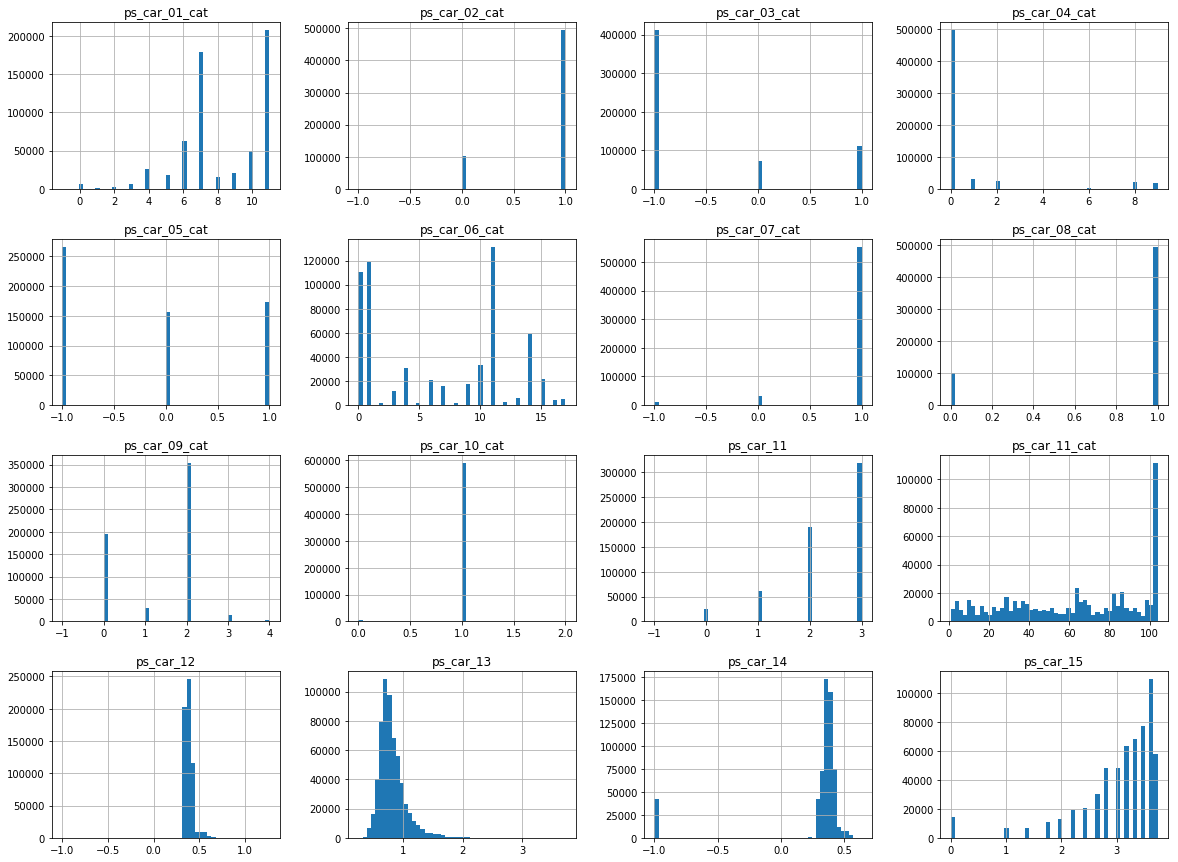

In [11]:
#histogram for each 'Car-related' feature in the dataset
training_data.iloc[:, 23: 39].hist(bins = 50, figsize = (20, 15))
plt.show()

The 'car-related' features consist of a range of categorical, binary and numeric features. Some have a significant number of missing values, however these may in themselves provide explanatory power.

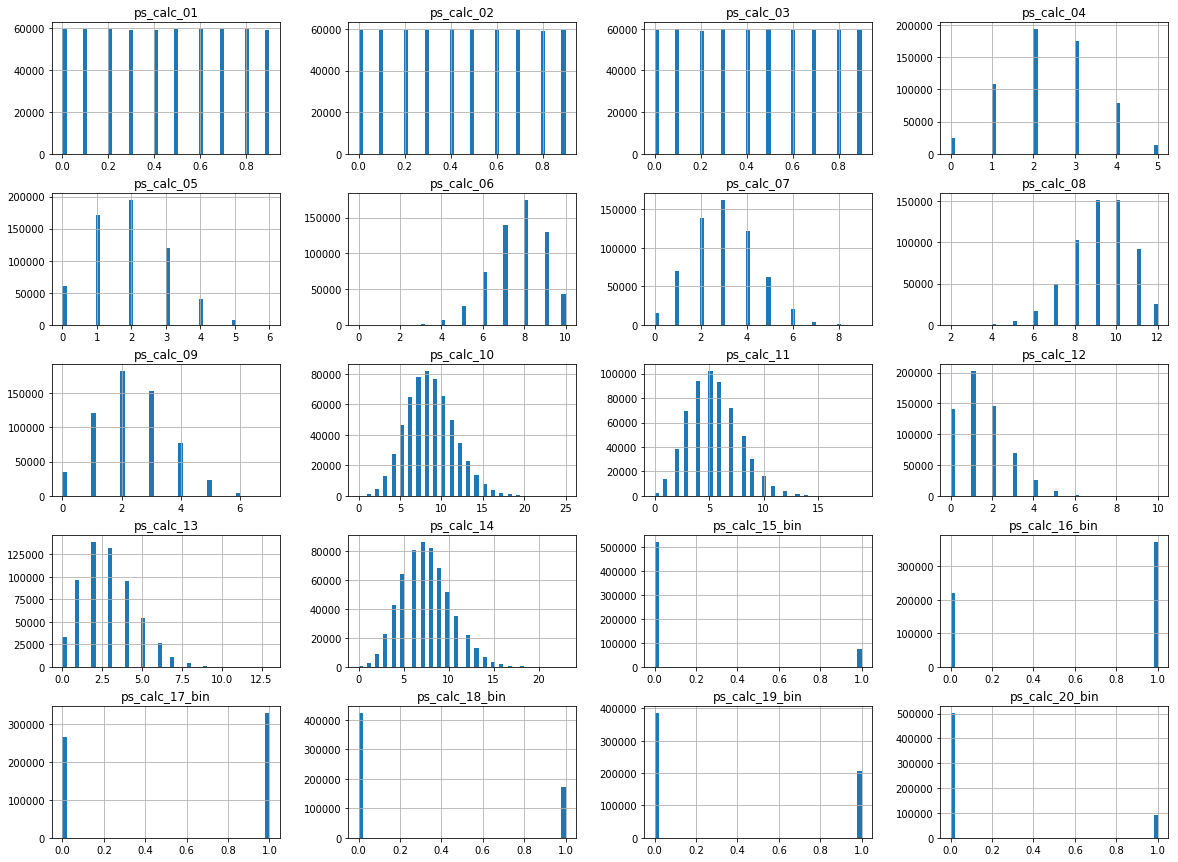

In [12]:
#histogram for each 'Calculated (engineered)' feature in the dataset
training_data.iloc[:, 39:].hist(bins = 50, figsize = (20, 15))
plt.show()

None of the engineered features contain missing values and the continuous features also contain no obvious outliers, so standardising these features to lie in the interval (0,1) should not be adversely affected by the presence of outlying observations.

In [13]:
#Proportion of target instances that made a claim (1) and didn't make a claim (0)
training_data["target"].value_counts() / len(training_data)

0    0.963552
1    0.036448
Name: target, dtype: float64

The correlation matrix can be used to assess if there are any linear relationships between the target variable and the attributes in the training dataset:

In [14]:
corr_matrix = training_data.corr()
corr_matrix["target"].sort_values(ascending = False)

target            1.000000
ps_car_13         0.053899
ps_car_12         0.038790
ps_ind_17_bin     0.037053
ps_reg_02         0.034800
ps_ind_07_bin     0.034218
ps_car_04_cat     0.032900
ps_car_03_cat     0.032401
ps_reg_03         0.030888
ps_ind_05_cat     0.029165
ps_car_15         0.027667
ps_reg_01         0.022888
ps_car_05_cat     0.020754
ps_ind_01         0.018570
ps_car_01_cat     0.016256
ps_ind_08_bin     0.013147
ps_car_06_cat     0.011537
ps_ind_04_cat     0.009360
ps_ind_03         0.008360
ps_ind_12_bin     0.007810
ps_ind_14         0.007443
ps_car_11_cat     0.006129
ps_car_09_cat     0.005322
ps_ind_18_bin     0.004555
ps_ind_02_cat     0.004534
ps_ind_13_bin     0.002460
ps_ind_11_bin     0.002028
ps_calc_03        0.001907
ps_ind_10_bin     0.001815
ps_calc_01        0.001782
ps_calc_14        0.001362
ps_calc_02        0.001360
ps_calc_10        0.001061
ps_car_10_cat     0.001038
ps_calc_05        0.000771
ps_calc_09        0.000719
ps_calc_16_bin    0.000624
p

The fact that many of the features show little correlation with the binary target suggests that either the features lack information to explain and predict the target binary response, or the features have non-linear relationships with the target variable and hence a more complex model, such as a Neural Network, which can work more effectively on datasets that are not linearly separable, could be used. Noticeably, some of the attributes exhibit very little correlation with the binary target variable and they may just be 'noise' and have no real relationship with the response. On the other hand, several features relating to the type of car that each individual insures appear to have greater correlation with the target variable. It could also be the case that missing values provide information about the probability of a claim; those individuals who are more likely to claim may provide less information in order to try reduce their insurance quotations.

## 4) Preparing the Data for Machine Learning Algorithms

### Missing Data

Most machine learning algorithms can't work with missing values. There are a number of strategies that could be used in order to deal with this problem (Geron, 2019):

***i) Get rid of the corresponding instances***

We have already seen that some features have a large number of missing values. Therefore, getting rid of the corresponding instances of these attributes will lead to a greatly reduced sample size and the loss of potentially important information.

***ii) Get rid of the whole attribute***

Many of the attributes with missing values have high correlation with the target. For example, 'ps_reg_03' has a relatively high correlation of 0.0324 with the target variable and a large number of missing values. Getting rid of this feature may lead to reduced predictive power.

***iii) Set the values to some value (e.g. the median)***

For the continuous and ordinal categorical features with many levels, it is natural that we might want to fill their missing values with some value, such as the median of that feature. However, it does not make sense to fill the missing values of binary features with their median value. Therefore, binary features with missing values are converted to multinomial features, with a new category representing missing values.

We use a preparation pipeline to prepare the data for a machine learning algorithm, ensuring that all binary and continous features are correctly added to the model. We separate the features into two types, with different transformations carried out on each of the two types of feature:

a) Continuous and Categorical Features

For these features, missing values are inputted using the median value of that respective feature, using $SimpleImputer$. Then the data is normalized to lie in the interval (0,1) (via $MinMaxScaler$). Neural Networks generally expect an input value between 0 and 1 and as previously discussed, there are no extreme outliers so this scaling method is not unduly affected by outliers, providing justification for scaling these featues in this way. The categorical features have a natural ordering and  are already encoded numerically, so there is no need to separate them into further columns using dummy indexing.

b) Binary Features

The missing values are used as factor levels, which changes these features from binary to multinomial, as individuals with missing values may provide predictive power and information. The missing values are first converted to the number 2, so that they can be appropriately encoded using the $OneHotEncoder$ (this does not accept negative integers). 

Given the low correlation between the target and some features, there may be a case for dropping some features from the models that we later fit. However, the correlation coefficient only measures linear correlations and may completely miss nonlinear relationships (Geron, 2019). Therefore, given the complex nature of the data, we retain all features when fitting each model.

In [15]:
#Split the training data into the labels and features
training_labels = training_data["target"]
training_features = training_data.drop(["target", "id"], axis = 1)

We first need to fill in the missing values for the ordinal categorical and numerical features, so that we can impute the median values for these features.

In [16]:
#Extract the features that we will treat as numerical
num_attributes = ["ps_ind_01", "ps_ind_02_cat", "ps_ind_03", "ps_ind_05_cat", "ps_ind_14", "ps_ind_15", "ps_reg_01", 
                  "ps_reg_02", "ps_reg_03", "ps_car_01_cat", "ps_ind_04_cat", "ps_car_04_cat", "ps_car_06_cat", 
                  "ps_car_09_cat", "ps_car_10_cat", "ps_car_11", "ps_car_11_cat", "ps_car_12", "ps_car_13", 
                  "ps_car_14", "ps_car_15", "ps_calc_01", "ps_calc_02", "ps_calc_03", "ps_calc_04", "ps_calc_05", "ps_calc_06", 
                  "ps_calc_07", "ps_calc_08", "ps_calc_09", "ps_calc_10", "ps_calc_11", "ps_calc_12", "ps_calc_13", "ps_calc_14"]

We replace the -1 values (corresponding to missing values) for these features with NA, so that we can then impute the median of each feature in place of the missing values.

In [17]:
#replace the numerical features with missing values encoded as NA for training data
training_features[num_attributes] = training_features[num_attributes].replace(-1,np.NaN)

In [18]:
#replace the numerical features with missing values encoded as NA for test data
test_data[num_attributes] = test_data[num_attributes].replace(-1,np.NaN)

In [19]:
#The numerical missing values have now been fillied with NA's
training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 57 columns):
ps_ind_01         595212 non-null int64
ps_ind_02_cat     594996 non-null float64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595129 non-null float64
ps_ind_05_cat     589403 non-null float64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_reg_03         487440 non-null float64
ps_car_01_cat     595105 non-null flo

In [20]:
#Import relevant packages
#MinMaxScaler to normalize the features
from sklearn.preprocessing import MinMaxScaler
#SimpleImputer to impute the median values in place of missing values
from sklearn.impute import SimpleImputer
#Pipeline to create transformation pipelines to process the data
from sklearn.pipeline import Pipeline

In [21]:
#Pipeline for the features that we treat as numerical
num_pipeline = Pipeline([
    #Impute missing values with the median
    ('imputer', SimpleImputer(strategy = "median")),
    #Standardise values to lie in the range [0,1]
    ('min_max_scaler', MinMaxScaler())
])

Now consider the binary features, which will become multinomial with three levels, once we specify the missing values as a new factor level. After converting these features to multinomial, we apply One Hot Encoding. This creates one binary attribute per category, adding two extra columns for each of these features to the feature matrix.

In [22]:
#extract binary features
cat_attributes = ["ps_ind_06_bin", "ps_ind_07_bin", "ps_ind_08_bin", "ps_ind_09_bin", "ps_ind_10_bin", "ps_ind_11_bin", 
                  "ps_ind_12_bin", "ps_ind_13_bin", "ps_ind_16_bin", "ps_ind_17_bin", "ps_ind_18_bin", "ps_car_02_cat", 
                  "ps_car_03_cat", "ps_car_05_cat", "ps_car_07_cat", "ps_car_08_cat", "ps_calc_15_bin", "ps_calc_16_bin", 
                  "ps_calc_17_bin", "ps_calc_18_bin", "ps_calc_19_bin", "ps_calc_20_bin"]

In [23]:
#Replace -1 with 2 as the OneHotEncoder can't work for negative integers
training_features[cat_attributes] = training_features[cat_attributes].replace(-1,2)

In [24]:
#apply OneHotEncoding again, now for the test data
test_data[cat_attributes] = test_data[cat_attributes].replace(-1,2)

In [25]:
from sklearn.preprocessing import OneHotEncoder

In [26]:
from sklearn.compose import ColumnTransformer
full_pipeline = ColumnTransformer([
    #pipeline for numerical features
    ("num", num_pipeline, num_attributes),
    #OneHotEncoder for (previously) binary features
    ("cat", OneHotEncoder(), cat_attributes)
])

In [27]:
#use pipeline to prepare training data
training_prepared = full_pipeline.fit_transform(training_features)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [28]:
#transform the test data based on the scaling estimated from the training data
test_prepared = full_pipeline.transform(test_data)

### 5) The Confusion Matrix and ROC Curve as Measures of Model Performance

It is important, before carrying out the model selection procedure, to consider an appropriate measure of model performance. This avoids biases that may occur when selecting a performance measure after different models have been fit.

In the given situation, using accuracy as a measure of performance is not suitable, because all the models fitted predict very low probabilities that individuals will make a claim and hence using the standard threshold probability of 0.5, always predict that individuals will not make a claim (i.e. always predict a negative). This is caused by the low rate of individuals making a claim within a year (just 3.64%) and the lack of information contained within the features relating to the binary target.

In [29]:
#Proportion of positive and negative target values ('claim' Vs 'no claim') in the training data
print("Proportion of individuals who didn't make a claim:", round((573518 / (21694 + 573518)), 4))
print("Proportion of individuals who made a claim:", round((21694 / (21694 + 573518)), 4))

Proportion of individuals who didn't make a claim: 0.9636
Proportion of individuals who made a claim: 0.0364


Accuracy also ignores the types of errors that are made. In the context of automotive insurance, incorrectly predicting that an individual won't claim when they actually do (false negatives) will be more costly (financially) to Porto Seguro than incorrectly predicting that an individual will claim and then they actually don't (false positives). Hence, more emphasis should be placed on reducing the false negative rate. The ROC curves of different models and the ROC AUC scores can be compared to assess model performance in this manner. The ROC curve plots the true positive rate against the falser postive rate. The true postive rate (recall) takes into account false negatives, as it is the ratio of positive instances that are correctly detected by the classifier:

$$Recall = True Positive Rate = \frac{TP}{TP + FN}$$

Thus, if the number of false negatives increases, the recall will fall. The ROC curve also allows us to assess the trade-off between the true positive rate (recall) and the false positive rate; the higher the recall, the higher the false positive rate will be, on average. That is, if the recall rises, this may be due to the fact we are always predicting a positive outcome, however conequently this will lead to an increase in the number of false positive that are predicted. Thus, this measure of performance enables us to assess this trade-off and incorporate the problems of false negative classification. The Area Under the Curve (AUC) provides a quantitative measure of performance between models, calculating the area under the ROC curve for a given model. A higher AUC score indicates a better performing model.

## 5) Selection and Training of Models

The No Free Lunch Theorem states that if we make absolutely no assumptions about the data, then there is no reason to prefer one model over another. The only way to know for sure is to evaluate them all (Geron, 2019). However, in practice we can make a few reasonable assumptions about the data. the Porto Seguro automotive insurance data provides a range of features; categorical, numeric and binary. We have shown that most of the variables have little correlation with the binary target variable of 'claim' or 'no claim'. This suggests that a more complex model, such as a neural network may be beneficial to make predictions for datasets that are not close to being linearly separable. However, given the large number of features in relation to the size of the data, we expect that neural networks may not achieve their 'potential' as they may overfit the data quite quickly. This suggests that more simple methods for classification, such as logistic regression may also perform relatively well when making predictions on unseen data. Finally, we fit a Random Forest classification model to the training data and again assess its performance using cross-validation. Random Forest models are Ensemble Methods that average out the predictions of decision trees and introduce extra randomness when growing trees, resulting in extra tree diversity (different features are used to split nodes, not necessarily the optimal features) that leads to an increase in bias and a reduced variance. This may enable random forest models to generalize better to unseen data.

### Cross-Validation

K-Fold Cross Validation is a common way to evaluate different models (and with different hyperparameters). This process splits the training data into k folds (here k = 3), where (k-1) of the folds are used to train the model, the performance of which is then assessed by comparing its predictions to the target values of the unused fold, which acts as a validation set. This ensures the model is assessed on instances that were previously unseen when fitting the model.

Cross-Validation allows one to assess potential issues of overfitting and underfitting across models and provides an estimate of how each model will generalize to an independent sample of unseen data. Using this approach, we can train multiple models using different hyperparameters on the reduced training set and select the model that performs best on average for each of the k validation folds.

All models discussed are types of supervised machine learning; the training set fed into the algorithm includes the desired solutions (binary classifications) called labels.

### a) Logistic Regression

Logistic regression can be used to estimate the probability that a given instance belongs to one of the binary classes. In a similar manner to linear regression, logistic regression computes a weighted sum of input features, plus a bias term. However, it then uses the logistic function to output a number (probability) between 0 and 1. The weights used in the regression are estimated by minimizing the log loss function:

$$J(\theta) = \frac{-1}{m}\sum_{i=1}^{m}[ y^i \log(p^i) + (1 - y^i) \log(1 - p^i)]$$

That is, when the true value (label) for a given instance is 1 ('claim', i.e. $y^i = 1$), the loss for individual i becomes $\log(p^i)$. Hence, a higher predicted probability leads to a reduced loss in this case and when $p^i = 1$, $\log(p^i) =0$ and the loss or cost for instance i is zero. Hence, on average, the optimal solution will predict low probabilities for instances/ individuals that did not make a claim and high probabilities for those that did make a claim, using the input features, to minimize this loss. Logistic Regression can be used for binary classification by specifying a threshold probability, beyond which an instance is predicted to make a claim.

In [30]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state = 160001695)

In [31]:
from sklearn.model_selection import cross_val_predict

We now use cross-validation to train the model on 

In [33]:
#extract the predicted probabilities for the k validation sets
y_train_pred = cross_val_predict(log_reg, training_prepared, training_labels, cv = 3,  method = "predict_proba")

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [34]:
#predicted values of a 'claim' (target = 1)
logistic_predictions = y_train_pred[:,1]

Now we can look at the ROC curve to assess the performance of the model

In [35]:
from sklearn.metrics import roc_curve

#false positve rate, true positive rate, probability thresholds
fpr, tpr, thresholds = roc_curve(training_labels, logistic_predictions)

In [36]:
#Create a function to plot the ROC curve
def plot_roc_curve(fpr, tpr, label = None):
    #plot roc curve for fitted model
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    #Add line for random guess model
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate (Recall)', fontsize = 14)
    plt.grid(True)
    plt.title('ROC Curve', fontsize = 18)

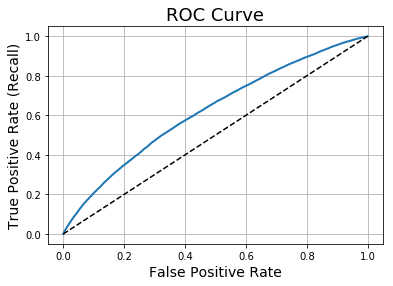

In [37]:
plot_roc_curve(fpr, tpr, "Logistic Regression")
plt.savefig("roc_curve1.png")
plt.show()

Now we assess the area under the curve (AUC) For the Receiver Operating Characteristic (ROC) Curve:

In [38]:
from sklearn.metrics import roc_auc_score
print("AUC Score for the Logistic Regression Model:", round(roc_auc_score(training_labels, logistic_predictions), 4))

AUC Score for the Logistic Regression Model: 0.6215


### b) Random Forest Model

A Random Forest is an ensemble of decision trees, which makes predictions by taking a weighted average of the probabilities (in this case) of each tree. It also introduces extra randomness when growing trees; instead of always splitting a node by the best feature (as determined by the training set), it searches for the best feature among a random subset of the features. This may allow the model to improve its ability to generalize to new datasets, by raising its bias but reducing its variance in making predictions on new, unseen data. 

Each individual decision tree that makes up the Random Forest is estimated using the CART Training Algorithm. This is a 'greedy' algorithm, in that it greedily searches the optimal feature and threshold to split the data by, without considering whether this split will lead to the best gini impurity several levels down. Thus, this model is often considered as reasonable but not optimal. Regularization for the tree can simply be controlled via the maximum depth of each decision tree, which here is set to 3.

Use Scikit-Learn's SGD classifier as a method for binary classification

In [39]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 160001695, max_depth = 3)
#extract predicted probabilities for the k validation sets
y_probas_forest = cross_val_predict(forest_clf, training_prepared, training_labels, cv = 3, method = "predict_proba")

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [40]:
#false positive rate, true positive rate, probability thresholds
fpr_rf, tpr_rf, thresholds_rf = roc_curve(training_labels, y_probas_forest[:,1])

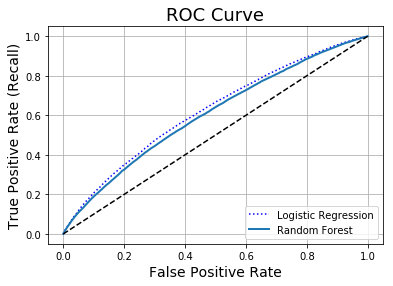

In [41]:
#Plot the ROC curves for logistic and random forest models
plt.plot(fpr, tpr, "b:", label = "Logistic Regression")
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [42]:
print("AUC Score for the Random Forest Model:", round(roc_auc_score(training_labels, y_probas_forest[:,1]), 4))

AUC Score for the Random Forest Model: 0.6036


We see that the performance of the Random Forest Regressor is not as good as that of the Logistic Regression model, as measured by the ROC curve and AUC score. In particular, the ROC curve for the Random Forest model lies under that of the Logistic Regression model for all thresholds. Hence, for a given false positive rate, the true positive rate for the random forest model is smaller, suggesting it is underestimating probabilities for those individuals that made a claim. This information is confirmed by the lower AUC score of 0.6036.

### c) Neural Network

Multilayer perceptrons can be used to create a classification model for this task. For a binary classification problem, we require a single output neuron using the logistic activation function (Geron, 2019). The output will be a number between zero and one, which can be interpreted as the estimated probability of the positive class (making a claim).

A perceptron with a single layer and single neuron (i.e. a threshold logic unit, TLU) is equivalent to a logistic regression model, as it computes a linear combination of feature inputs and uses the sigmoid function to transform these weighted linear combinations into a probability lying in the interval (0,1). Multilayer perceptrons are composed of an input layer, one or more layers of TLU's, called hidden layers and the output layer. Every layer except the outer layer contains a bias neuron and is fully connected to the next layer. Hence, by adding more layers, we hope to train a model that improves upon the Logistic Regression model in terms of its predictive performance as measured by AUC.

The model is trained using backpropagation. This works by splitting the input data used to train the model into 'mini-batches'. Each mini-batch of data is passed through the model and the network's output error is measured by a loss function, in this case for the sigmoid function, which is the same as that of the logistic regression loss function: 

$$J(\theta) = \frac{-1}{m}\sum_{i=1}^{m}[ y^i \log(p^i) + (1 - y^i) \log(1 - p^i)]$$

where m is the number of instances in the mini-batch fed in to the neural network. Then the contribution to this error of the outputs from each neuron is computed. This is a reverse pass, and measures the error gradient backward through the network. The connection weights for each neuron are then corrected using Gradient Descent to reduce the error. One cycle of a forward and reverse pass is known as an epoch. 

In [43]:
#import tensorflow and keras for neural networks
import tensorflow as tf
from tensorflow import keras

We first fit a Neural Network with two hidden layers and ten neurons per layer, using the default learning rate. Later these hyperparameters are tuned to search for a better model as assessed by AUC.

In [44]:
Neural_Net = keras.models.Sequential([
    #first hidden layer
    keras.layers.Dense(10, activation = "relu", input_shape = training_prepared.shape[1:]),
    #second hidden layer
    keras.layers.Dense(10, activation = "relu"),
    #output neuron
    keras.layers.Dense(1, activation = "sigmoid")
])    

In [45]:
#Compile model
Neural_Net.compile(loss = "binary_crossentropy", 
                  optimizer = "sgd", metrics = ["accuracy"])

We now create a function that carries out K-fold cross-validation on the Neural Net model. This is customized to calculate the AUC score as the measure of performance for each fold and then the AUC score is later averaged across the folds to provide a final score for the model.

In [46]:
#KFold function splits data into k consecutive folds
from sklearn.model_selection import KFold

Each of the three Neural Nets is trained with just 3 epochs to reduce computational time and allow for a quicker assessment of models:

In [49]:
#Carry out K-Fold cross-validation with k = 3 folds by default
def Neural_Net_CrossVal(Neural_Net, k = 3, random_state = 160001695, epochs = 3):
    #empty array to store predictions
    NN_pred = np.zeros(len(training_labels))
    for train_index,test_index in KFold(k, random_state = 160001695).split(training_prepared):
        #split data into training and test set
        x_train, x_test=training_prepared[train_index], training_prepared[test_index]
        #split corresponding test and training labels
        y_train, y_test=training_labels[train_index], training_labels[test_index]
        #Fit model on training set
        Neural_Net.fit(x_train, y_train,epochs= epochs)
        #Make predictions on test test
        NN_pred = Neural_Net.predict(x_test)
        #Calculate AUC score for the kth fold
        print("AUC cross-validation score: ", round(roc_auc_score(y_test, NN_pred), 5))

In [50]:
#Carry out cross-validation on the model
Neural_Net_CrossVal(Neural_Net, k = 3)

Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 72s 180us/sample - loss: 0.1558 - accuracy: 0.9637
Epoch 2/3
396808/396808 [==============================] - 68s 172us/sample - loss: 0.1542 - accuracy: 0.9637
Epoch 3/3
396808/396808 [==============================] - 72s 182us/sample - loss: 0.1538 - accuracy: 0.9637
AUC cross-validation score:  0.60311
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 66s 167us/sample - loss: 0.1545 - accuracy: 0.9634
Epoch 2/3
396808/396808 [==============================] - 63s 160us/sample - loss: 0.1542 - accuracy: 0.9634
Epoch 3/3
396808/396808 [==============================] - 71s 180us/sample - loss: 0.1541 - accuracy: 0.9634- loss: 0.1541 - ac
AUC cross-validation score:  0.61718
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 58s 146us/sample - loss: 0.1534 - accuracy: 0.9636
Epoch 2/3
396808/396808 [==============================] - 66s 16

In [67]:
print("Average AUC score", (0.60311 + 0.61718 + 0.61913) / 3)

Average AUC score 0.6131399999999999


Therefore, we see that the average AUC score for the neural network model (0.61314) is slightly lower than that of the logistic regression model (0.6215). We can also see that the accuracy is roughly equal to the proportion of individuals in the training set who made a claim. As the predicted probabilities are so low, all individuals are predicted as not claiming and hence the accuracy is a useless measure of model performance in this case.

## 7) Fine-Tune Models

Given the results of the AUC scores, we now only consider hyperparameter tuning of the Neural Net as there is evidence that this model may provide the best predictions on unseen data if the hyperparameters are tuned well enough to improve model performance beyond that of the logistic regression model. Because the AUC score is not a standard metric in keras, we use the cross-validation function and manually assess models with different hyperparameters, instead of using grid search. The first neural network model that we fitted had two hidden layers, each with 10 neurons and used the default learning rate of 0.001. 

In order to assess the performance of the neural network binary classifier, we use the custom cross validation function that calculates the AUC score for each fold for each set of hyperparameters. By testing on the unseen fold, an unbiased assessment of how each model might generalize to new data can be carried out.

There are several different hyperparameters for the neural network that we consider:

***a) Number of Hidden Layers***

For many problems, a single hidden layer can provide reasonable results. However, given the (relatively) complex nature of this problem, with a large number of fairly uninformative features, adding more layers may improve the predictive ability of a neural network.

***b) Number of Neurons per hidden layer***

As the number of neurons per layer increases, we expect the predictive power of the model to increase. However, as with the number of hidden layers, overfitting may become an issue if too many neurons are added per layer, so cross-validation can be used to find an optimal trade-off of bias and variance of the probability predictions.

***c) Learning Rate***

This hyperparameter determines the size of steps that the gradient descent takes when minimizing the sigmoid cost function. The lower the learning rate, the more iterations the gradient descent algorithm will take to converge. However, if the learning rate is too high, the algorithm may overshoot and diverge. The learning rate is one of the most influential hyperparameters in fitting a Neural network, so we consider three different values and compare their performance to the original learning rate of 1e-3.

We now create a function that can build simple Sequential Neural Networks for a given set of input values: 

In [51]:
def build_model(n_hidden = 1, n_neurons = 30, learning_rate = 3e-3):
    #Define the keras model
    model = keras.models.Sequential()
    #Add an input layer
    model.add(keras.layers.InputLayer(input_shape = training_prepared.shape[1:]))
    for layer in range(n_hidden):
        #Assume each hidden layer contains the same number of neurons
        model.add(keras.layers.Dense(n_neurons, activation = "relu"))
    #Add the output layer
    model.add(keras.layers.Dense(1, activation = "sigmoid"))
    #Use SGD for backpropagation
    optimizer = keras.optimizers.SGD(lr = learning_rate)
    #compile model
    model.compile(loss = "binary_crossentropy", optimizer = optimizer)
    return model

### a) Number of Hidden Layers

We use the customized cross-validation function to assess the performance of the original neural network model but instead with 1 and 3 hidden layers.

In [52]:
#Then manually compare each model by considering cross-validation
Neural_Net_CrossVal(build_model(n_hidden = 1, n_neurons = 10), k = 3)

Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 57s 145us/sample - loss: 0.1757
Epoch 2/3
396808/396808 [==============================] - 57s 142us/sample - loss: 0.1552
Epoch 3/3
396808/396808 [==============================] - 69s 175us/sample - loss: 0.1546
AUC cross-validation score:  0.58507
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 62s 156us/sample - loss: 0.1552
Epoch 2/3
396808/396808 [==============================] - 57s 143us/sample - loss: 0.1550
Epoch 3/3
396808/396808 [==============================] - 56s 142us/sample - loss: 0.1548
AUC cross-validation score:  0.59959
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 53s 132us/sample - loss: 0.1540
Epoch 2/3
396808/396808 [==============================] - 66s 166us/sample - loss: 0.1539
Epoch 3/3
396808/396808 [==============================] - 63s 158us/sample - loss: 0.1538
AUC cross-validation score:  0.6067

In [75]:
print("Average AUC score", round(((0.58507 + 0.59959 + 0.60671) / 3), 4))

Average AUC score 0.5971


In [53]:
Neural_Net_CrossVal(build_model(n_hidden = 3, n_neurons = 10), k = 3)

Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 71s 178us/sample - loss: 0.1575
Epoch 2/3
396808/396808 [==============================] - 65s 164us/sample - loss: 0.1548
Epoch 3/3
396808/396808 [==============================] - 55s 139us/sample - loss: 0.1542
AUC cross-validation score:  0.59475
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 55s 138us/sample - loss: 0.1548
Epoch 2/3
396808/396808 [==============================] - 54s 136us/sample - loss: 0.1546
Epoch 3/3
396808/396808 [==============================] - 56s 140us/sample - loss: 0.1545
AUC cross-validation score:  0.60568
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 59s 149us/sample - loss: 0.1537
Epoch 2/3
396808/396808 [==============================] - 60s 151us/sample - loss: 0.1536
Epoch 3/3
396808/396808 [==============================] - 57s 144us/sample - loss: 0.1535
AUC cross-validation score:  0.6113

In [76]:
print("Average AUC score", round(((0.59475 + 0.60568 + 0.6113) / 3),4))

Average AUC score 0.6039


We can see that the neural network might be suffering from issues of overfitting for 3 hidden layers and underfitting for 1 hidden layer, as reflected by the lower AUC scores in comparison to the original Neural Network model with just 1 hidden layer.

### b) Number of Neurons per Hidden Layer

Again apply the custom cross-validation function to models with 5 and 15 neurons in each of the two hidden layers.

In [54]:
Neural_Net_CrossVal(build_model(n_hidden = 2, n_neurons = 5), k = 3)

Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 57s 145us/sample - loss: 0.1595
Epoch 2/3
396808/396808 [==============================] - 56s 141us/sample - loss: 0.1556
Epoch 3/3
396808/396808 [==============================] - 55s 140us/sample - loss: 0.1548
AUC cross-validation score:  0.57591
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 62s 156us/sample - loss: 0.1554
Epoch 2/3
396808/396808 [==============================] - 58s 146us/sample - loss: 0.1551
Epoch 3/3
396808/396808 [==============================] - ETA: 0s - loss: 0.154 - 56s 141us/sample - loss: 0.1549
AUC cross-validation score:  0.59693
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 58s 147us/sample - loss: 0.1542
Epoch 2/3
396808/396808 [==============================] - 60s 150us/sample - loss: 0.1540
Epoch 3/3
396808/396808 [==============================] - 58s 146us/sample - loss: 0.1539
AUC cross-v

In [78]:
print("Average AUC score", round(((0.57591 + 0.59693 + 0.60563) / 3),4))

Average AUC score 0.5928


In [55]:
Neural_Net_CrossVal(build_model(n_hidden = 2, n_neurons = 15), k = 3)

Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 59s 148us/sample - loss: 0.1587
Epoch 2/3
396808/396808 [==============================] - 56s 142us/sample - loss: 0.1545
Epoch 3/3
396808/396808 [==============================] - 60s 152us/sample - loss: 0.1540
AUC cross-validation score:  0.59848
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 59s 148us/sample - loss: 0.1547
Epoch 2/3
396808/396808 [==============================] - 58s 146us/sample - loss: 0.1545
Epoch 3/3
396808/396808 [==============================] - 58s 147us/sample - loss: 0.1543
AUC cross-validation score:  0.60942
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 58s 146us/sample - loss: 0.1536
Epoch 2/3
396808/396808 [==============================] - 61s 155us/sample - loss: 0.1535
Epoch 3/3
396808/396808 [==============================] - 62s 157us/sample - loss: 0.1534
AUC cross-validation score:  0.6144

In [79]:
print("Average AUC score", round(((0.59848 + 0.60942 + 0.61443) / 3), 4))

Average AUC score 0.6074


Similarly, the AUC scores for 5 and 15 neurons per hidden layer are lower than the AUC score for 10 hidden layers.

### c) Learning Rate

Finally, we compare the sensitivity of the AUC score for the models under cross-validation for different values of the learning rate (1e-4 and 1e-2).

In [65]:
Neural_Net_CrossVal(build_model(n_hidden = 2, n_neurons = 10, learning_rate = 1e-4), k = 3)

Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 61s 154us/sample - loss: 0.2657
Epoch 2/3
396808/396808 [==============================] - 58s 145us/sample - loss: 0.1578
Epoch 3/3
396808/396808 [==============================] - 57s 145us/sample - loss: 0.1569
AUC cross-validation score:  0.53327
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 62s 156us/sample - loss: 0.1577
Epoch 2/3
396808/396808 [==============================] - 59s 148us/sample - loss: 0.1576
Epoch 3/3
396808/396808 [==============================] - 58s 147us/sample - loss: 0.1575
AUC cross-validation score:  0.54585
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 58s 147us/sample - loss: 0.1568
Epoch 2/3
396808/396808 [==============================] - 61s 153us/sample - loss: 0.1567
Epoch 3/3
396808/396808 [==============================] - 61s 154us/sample - loss: 0.1566 
AUC cross-validation score:  0.551

In [80]:
print("Average AUC score", round(((0.53327 + 0.54585 + 0.55127) / 3), 4))

Average AUC score 0.5435


In [66]:
Neural_Net_CrossVal(build_model(n_hidden = 2, n_neurons = 10, learning_rate = 1e-2), k = 3)

Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 60s 152us/sample - loss: 0.1560 - loss: 
Epoch 2/3
396808/396808 [==============================] - 63s 158us/sample - loss: 0.1539
Epoch 3/3
396808/396808 [==============================] - 64s 161us/sample - loss: 0.1535
AUC cross-validation score:  0.61233
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - ETA: 0s - loss: 0.154 - 60s 151us/sample - loss: 0.1542
Epoch 2/3
396808/396808 [==============================] - 64s 162us/sample - loss: 0.1540
Epoch 3/3
396808/396808 [==============================] - 60s 152us/sample - loss: 0.1539
AUC cross-validation score:  0.61899
Train on 396808 samples
Epoch 1/3
396808/396808 [==============================] - 58s 147us/sample - loss: 0.1533
Epoch 2/3
396808/396808 [==============================] - 72s 180us/sample - loss: 0.1532
Epoch 3/3
396808/396808 [==============================] - 71s 178us/sample - loss: 0.1532
AU

In [81]:
print("Average AUC score", round(((0.61233 + 0.61899 + 0.61907) / 3), 4))

Average AUC score 0.6168


The results of this hyperparameter tuning support a model with two hidden layers, ten neurons per hidden layer and a learning rate of 1e-2 as the best trialled model, using the AUC score as a measure of performance, with an average AUC of 0.61689.

## 8) Assessing Model Performance

We now fit the updated Neural Network model with a learning rate of 1e-2, which was chosen as the optimal model with the highest AUC score but with 5 epochs to ensure convergence to the optimal weights at each layer (we would have used more epochs but that was too time consuming for this PC). The fitted model is then used to make predictions on the training set via cross-validation and the ROC curve is plotted to get a more accurate assessment of the model's performance.

In [82]:
#Final model with 2 hidden layers, 10 neurons per hidden layer and a learning rate of 0.01
NN_final = build_model(n_hidden = 2, n_neurons = 10, learning_rate = 1e-2)

In [87]:
#Compile Model
NN_final.compile(loss = "binary_crossentropy", 
                  optimizer = "sgd", metrics = ["accuracy"])
#Fit model to training data
NN_final.fit(training_prepared, training_labels, epochs = 5)
#Extract predicted probabilities on the test set
y_pred = NN_final.predict(test_prepared)

Train on 595212 samples
Epoch 1/5
595212/595212 [==============================] - 91s 154us/sample - loss: 0.1541 - accuracy: 0.9636
Epoch 2/5
595212/595212 [==============================] - 89s 150us/sample - loss: 0.1537 - accuracy: 0.9636
Epoch 3/5
595212/595212 [==============================] - 93s 156us/sample - loss: 0.1536 - accuracy: 0.9636
Epoch 4/5
595212/595212 [==============================] - 90s 152us/sample - loss: 0.1535 - accuracy: 0.9636
Epoch 5/5
595212/595212 [==============================] - 90s 151us/sample - loss: 0.1534 - accuracy: 0.9636


We now calculate the AUC score for the final model, however this time we train each fold on 5 epochs to ensure convergence to the optimal weights at each layer. We then average the AUC score for each fold to estimate the overall AUC score.

In [88]:
def Neural_Net_Final_CrossVal(Neural_Net, k = 3, random_state = 160001695, epochs = 5):
    #empty array to store predictions
    NN_pred = np.zeros(len(training_labels))
    for train_index,test_index in KFold(k, random_state = 160001695).split(training_prepared):
        #split data into training and test set
        x_train, x_test=training_prepared[train_index], training_prepared[test_index]
        #split corresponding test and training labels
        y_train, y_test=training_labels[train_index], training_labels[test_index]
        #Fit model on training set
        Neural_Net.fit(x_train, y_train,epochs= epochs)
        #Make predictions on test test
        NN_pred = Neural_Net.predict(x_test)
        #Calculate AUC score for the kth fold
        print("AUC cross-validation score: ", round(roc_auc_score(y_test, NN_pred), 5))

In [89]:
Neural_Net_Final_CrossVal(NN_final, k = 3)

Train on 396808 samples
Epoch 1/5
396808/396808 [==============================] - 58s 146us/sample - loss: 0.1530 - accuracy: 0.9637
Epoch 2/5
396808/396808 [==============================] - 58s 146us/sample - loss: 0.1530 - accuracy: 0.9637
Epoch 3/5
396808/396808 [==============================] - 59s 149us/sample - loss: 0.1529 - accuracy: 0.9637
Epoch 4/5
396808/396808 [==============================] - 58s 146us/sample - loss: 0.1529 - accuracy: 0.9637
Epoch 5/5
396808/396808 [==============================] - 60s 151us/sample - loss: 0.1529 - accuracy: 0.9637
AUC cross-validation score:  0.62041
Train on 396808 samples
Epoch 1/5
396808/396808 [==============================] - 60s 150us/sample - loss: 0.1538 - accuracy: 0.9634
Epoch 2/5
396808/396808 [==============================] - 58s 147us/sample - loss: 0.1537 - accuracy: 0.9634
Epoch 3/5
396808/396808 [==============================] - 60s 152us/sample - loss: 0.1537 - accuracy: 0.9634
Epoch 4/5
396808/396808 [==========

In [96]:
print("Average AUC score", round(((0.62041 + 0.62102 + 0.6219) / 3), 4))

Average AUC score 0.6211


Whilst the AUC score provides a formal metric to assess the performance of each model, we may also consider plotting the ROC curve for the fitted Neural Network model and compare it to the ROC curves under Logistic Regression and the Random Forest classifier. Unfortunately, there is no easy way to extract all predictions from the Cross-Validation carried out, so we instead split the training data randomly into a training and validation set purely for the purpose of plotting a ROC curve to roughly illustrate the differences in performance between the different models. To do this, we randomly shuffle the indices of the data and split the test and training set into 80% training set and 20% validation set. We then approximate the true ROC curve using predictions solely on the validation set.

In [91]:
import random
#Set random seed for reproducibility
random.seed(160001695)
#shuffle indices of full training set
shuffled_indices = np.random.permutation(len(training_prepared))
#validation set is 20% of full training data
validation_set_size = int(len(training_prepared) * 0.2)
#extract the validation indices
validation_indices = shuffled_indices[:validation_set_size]
#extract the training indices
train_indices = shuffled_indices[validation_set_size:]
#create training set
train_set = training_prepared[train_indices]
#create validation set
validation_set = training_prepared[validation_indices]

In [92]:
#Train on the training data and predict for the validation data
NN_fit_ROC = NN_final.fit(train_set, training_labels[train_indices], epochs = 5)
NN_pred_ROC = NN_final.predict(validation_set)

Train on 476170 samples
Epoch 1/5
476170/476170 [==============================] - 83s 175us/sample - loss: 0.1533 - accuracy: 0.9635
Epoch 2/5
476170/476170 [==============================] - 80s 167us/sample - loss: 0.1532 - accuracy: 0.9635
Epoch 3/5
476170/476170 [==============================] - 70s 146us/sample - loss: 0.1532 - accuracy: 0.9635
Epoch 4/5
476170/476170 [==============================] - 71s 149us/sample - loss: 0.1532 - accuracy: 0.9635
Epoch 5/5
476170/476170 [==============================] - 71s 149us/sample - loss: 0.1532 - accuracy: 0.9635


In [93]:
#Extract the false positive rate, true positive rate and thresholds for the validation set predictions
fpr_NN, tpr_NN, thresholds_NN = roc_curve(training_labels[validation_indices], NN_pred_ROC[:, 0])

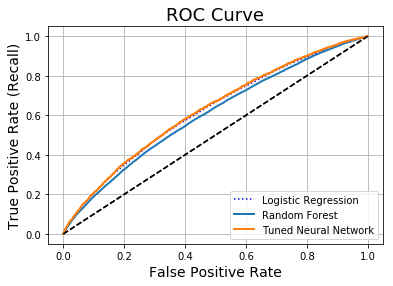

In [94]:
#Plot the ROC curve for all three different models assessed
plt.plot(fpr, tpr, "b:", label = "Logistic Regression")
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest")
plot_roc_curve(fpr_NN, tpr_NN, "Tuned Neural Network")
plt.legend(loc = "lower right")
plt.savefig("roc_curve.png")
plt.show()

The above ROC curve illustrates that the tuned Neural Network model tends to outperform the other fitted models for the majority of threshold values, when estimating its probabilities on the randomly sampled validation set. Despite having a slightly lower (but almost identical) AUC score of 0.6211 to that of the Logistic Regression model, the ROC curve seems to slightly favour the Tuned Neural Network model and hence we use this model as the final model to make predictions on the test data for upload to Kaggle (Also increasing the number of epochs to 20 for example would have likely raised the AUC Score for this model). 

[Note- both the AUC score and ROC Curves are dependent on how the data is split for each fold in the cross-validation process and this splitting is done randomly. Therefore, it is not contradictory that the ROC curve for the Tuned Neural Network is generally higher than that of the Logistic Regression model, despite the fact that the Logistic Regression model had a larger AUC score. This is because the AUC was calculated on a different set of sampled cross-validations. Essentially we have two seemingly equally performing models and in this case we choose the Neural Network. It may or may not generalize as well to the actual test data]

We now use the following code to upload the best model (Neural network with 2 hidden layers, 10 nodes per hidden layer and a learning rate of 1e-2) to kaggle:

In [97]:
#use fitted model to predict for test data
target_NN = NN_final.predict(test_prepared)

In [98]:
#extract probalities for 'claim'
target_NN = target_NN[:, 0]

In [100]:
#Extract identity column
identity = test_data["id"]
#Prepare the data into 2 columns for submission
submission = pd.DataFrame({'id': identity, 'target': target_NN})
filename = 'Porto Seguro Predictions.csv'
#Convert file to csv for Kaggle submission
submission.to_csv(filename,index=False)

## 9) Conclusion

In this project, we have assessed the performance of three models that could be used for binary classification for the Porto Seguro automotive insurance data. The three assessed models are: Logistic Regression, Random Forest Classifier and a Multi-Layer Perceptron Neural Network. The ROC curve and AUC score were used as measures of performance, as these take into account the false negative rate that could be more important for economic reasons to this insurance company. Cross-validation was then used to assess the performance of the different models, allowing an unbiased calculation of the AUC score by training a model and validating on a previously unseen kth fold of the data. The model that was chosen in the end was a Neural Network Multi-Layer Perceptron with two hidden layers, ten neurons per layer and a learning rate of 1e-2. Its AUC score was 0.6211 using three folds and five training epochs.

There are further methods that could also be considered beyond the analysis presented here to improve the performance of these models. Primarily, the number of features could be reduced and this may improve the tuning of neural networks as they may suffer less from overfitting, hence more layers could be added to create a model that acts on the reduced set of features which contain the most information. Principal component analysis could also be used to condense some of the numerical and categorical variables into new features containing most of the information (variation) from the original features, which would again slow the onset of overfitting and lead to potentially more powerful neural networks. 

## References

Geron, A. (2019). 'Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow', O'Reilly Media.

Severance, C. (2016). 'Python for Everybody: Exploring Data in Python 3', CreateSpace Independent Publishing Platform.

Python Software Foundation (2016). Python Language Reference, version 2.3. URL: http://www.python.org

RStudio Team (2016). RStudio: Integrated Development for R. RStudio, Inc., Boston, MA. URL: http://www.rstudio.com/.

Kaggle.com (2017). Porto Seguro's Safe Driver Prediction Data. URL: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data

Kaggle.com (2017). Porto Seguro's Safe Driver Prediction- Welcome. URL: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/40222